# Network Attack Outlier/Anomaly Detection

### Alon Firestein
ID: 314984402


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

In [4]:
df = pd.read_csv("conn250k.csv", header=None)
df.columns = ["record_ID", "duration", "src_bytes", "dst_bytes"]
pd.set_option('float_format', '{:f}'.format)
# df = df.set_index("record_ID")
df.head()

,record_ID,duration,src_bytes,dst_bytes
0,1,0,236,1228
1,2,0,239,486
2,3,0,234,1364
3,4,0,239,1295
4,5,0,181,5450


## Data Exploration and Visualization:

##### My plan is to start looking and exploring the data so that I can try and find "vulnerabilites" in the data that might indicate where to look to find outliers in the data. So using several panadas functions and plotting the data using matplotlib, I can have a better look and understanding of the dataset that I was given.

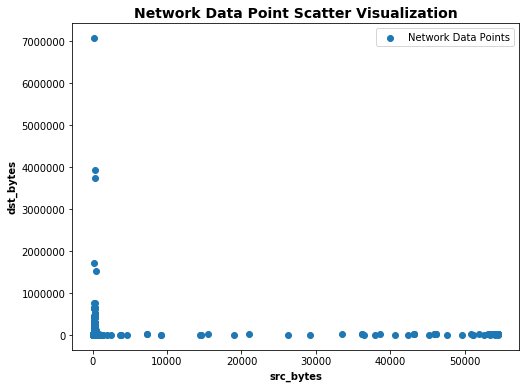

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(df['src_bytes'], df['dst_bytes'],label="Network Data Points")
plt.legend(loc="best")
plt.ylabel("dst_bytes", fontweight="bold")
plt.xlabel("src_bytes", fontweight="bold")
plt.title('Network Data Point Scatter Visualization', size = 14, fontweight="bold")
plt.show()

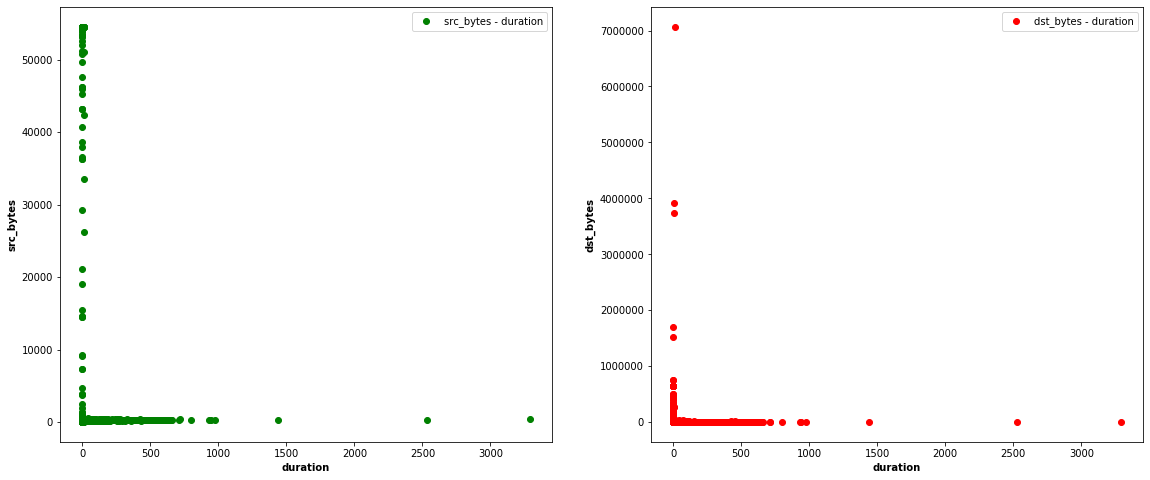

In [37]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.scatter(df['duration'], df['src_bytes'],label="src_bytes - duration", c='g')
plt.legend(loc="best")
plt.ylabel("src_bytes", fontweight="bold")
plt.xlabel("duration", fontweight="bold")
plt.subplot(132)
plt.scatter(df['duration'], df['dst_bytes'],label="dst_bytes - duration", c='r')
plt.legend(loc="best")
plt.ylabel("dst_bytes", fontweight="bold")
plt.xlabel("duration", fontweight="bold")
plt.show()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256670 entries, 0 to 256669
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   record_ID  256670 non-null  int64
 1   duration   256670 non-null  int64
 2   src_bytes  256670 non-null  int64
 3   dst_bytes  256670 non-null  int64
dtypes: int64(4)
memory usage: 7.8 MB


In [39]:
df.describe()

,record_ID,duration,src_bytes,dst_bytes
count,256670.000000,256670.000000,256670.000000,256670.000000
mean,128335.500000,0.640936,474.247898,4473.532614
std,74094.391134,15.627170,3391.106084,20809.034547
min,1.000000,0.000000,0.000000,0.000000
25%,64168.250000,0.000000,217.000000,660.000000
50%,128335.500000,0.000000,249.000000,1661.000000
75%,192502.750000,0.000000,306.000000,4341.000000
max,256670.000000,3289.000000,54540.000000,7068759.000000


In [40]:
# df.describe doesn't show the median so we'll show it here
df[["src_bytes", "dst_bytes"]].median()

src_bytes    249.000000
dst_bytes   1661.000000
dtype: float64

In [41]:
df.groupby(["src_bytes", "dst_bytes"])["duration"].mean()

src_bytes  dst_bytes
0          0           0.084615
           17520       0.000000
51         8127        4.500000
137        407         0.000000
138        492         0.000000
                         ...   
54060      7300        0.000000
54540      2920        0.000000
           7300        0.000000
           8314        0.092593
           8315        0.000000
Name: duration, Length: 134353, dtype: float64

In [42]:
# determining the precentage of missing data per column in the dataframe
df.apply(lambda x: sum(x.isna()) / len(df))

record_ID   0.000000
duration    0.000000
src_bytes   0.000000
dst_bytes   0.000000
dtype: float64

In [43]:
df.isna().sum()

record_ID    0
duration     0
src_bytes    0
dst_bytes    0
dtype: int64

In [44]:
df.nunique()

record_ID    256670
duration        368
src_bytes       473
dst_bytes     17063
dtype: int64

In [45]:
df.duplicated().sum()

0

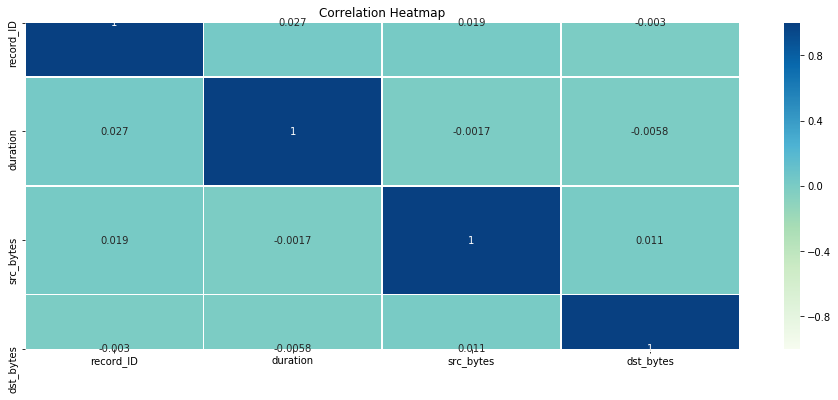

In [6]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="GnBu", linewidths=.5)
heatmap.set_title('Correlation Heatmap');

# Machine Learning:

##### Given that this is an unsupervised learning problem, and that the dataset does not contain a label for us to know which rows of data are actually real outliers. Then we can not use the train-test split method from sklearn because we cannot know how to split the data when we don't know the true labels. Therefore we will use an unsupervised algorithm called "Isolation Forest", which is based on the "Desicsion Tree" algorithm.

##### Given that I was given a second dataset that does indeed contain the true labels, I will import that dataset and use the true labels to check my models scores at the end (accuracy, precision, f-score, recall). Although the accuracy here doesn't have a real factor on our model because the dataset is so unbalanced that even if we told the model to predict "not an outlier" for every row, than we would have an accuracy score of over 99%. Therefore it is important to better rate our recall, precision, and f-1 scores.

In [14]:
from sklearn import metrics

df_true_labels = pd.read_csv("conn250K_anomaly.csv", header=None)
df_true_labels.columns = ["record_ID", "is_anomaly"]
# df_true_labels = df_true_labels.set_index("record_ID")

# Record_ID is useless data for detecting outliers, so we drop it from the dataframe
x = df.drop(['record_ID'], axis = 1)
# Retrieve the data as an array
data = x.values

## Isolation Forest:

#### The idea of using isolation forest is that it identifies anomalies by isolating outliers in the data. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In [49]:
from sklearn.ensemble import IsolationForest

contamination = 0.005
model = IsolationForest(n_estimators=50, contamination=contamination)

model.fit(data)
df['scores'] = pd.Series(model.decision_function(data))
df['anomaly'] = pd.Series(model.predict(data))
df.loc[df['anomaly'] == 1,'anomaly'] = 0
df.loc[df['anomaly'] == -1,'anomaly'] = 1
print(df['anomaly'].value_counts(),"\n\n")

df.head()

0    255410
1      1260
Name: anomaly, dtype: int64 




,record_ID,duration,src_bytes,dst_bytes,scores,anomaly
0,1,0,236,1228,0.133194,0
1,2,0,239,486,0.130601,0
2,3,0,234,1364,0.139203,0
3,4,0,239,1295,0.133150,0
4,5,0,181,5450,0.064510,0


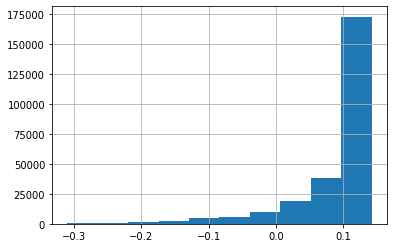

In [50]:
df['scores'].hist()

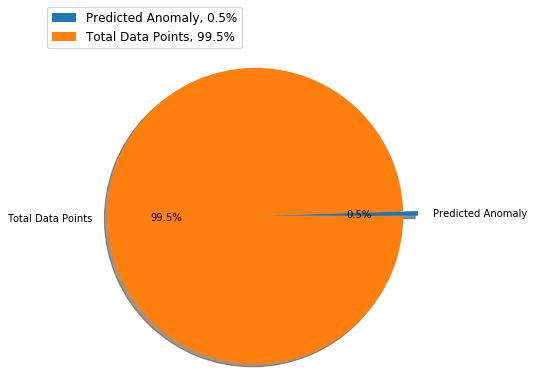

In [51]:
labels = 'Predicted Anomaly', 'Total Data Points'
total_predicted_anomaly = (df.anomaly==1).sum()
sizes = [total_predicted_anomaly/len(df), (len(df)-total_predicted_anomaly)/len(df)]
explode = (0.1, 0)  
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, autopct='%1.1f%%',labels=labels, shadow=True)
ax.axis('equal') 
total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 12},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig.transFigure
)
fig.set_size_inches(6, 6)
plt.rcParams['font.size'] = 12.0
plt.show()

In [52]:
print("Percentage of anomalies in data is: {:.2f}".format((len(df.loc[df['anomaly']==1])/len(df))*100))

Percentage of anomalies in data is: 0.49


In [53]:
print("-----------------Isolation Forest Report---------------\n")
print("Confusion Matrix:\n\n",metrics.confusion_matrix(df_true_labels['is_anomaly'], df['anomaly']),"\n","\n")
print("                      Classification Report:\n\n",
metrics.classification_report(df_true_labels['is_anomaly'], df['anomaly']),"\n","\n")
print('Accuracy Score of IsolationForest is:   {:.3f}'.format(metrics.accuracy_score(df_true_labels['is_anomaly'],df['anomaly'])))
print('F1 Score of IsolationForest is: \t{:.3f}'.format(metrics.f1_score(df_true_labels['is_anomaly'],df['anomaly'])))
print('Recall Score of IsolationForest is: \t{:.3f}'.format(metrics.recall_score(df_true_labels['is_anomaly'],df['anomaly'])))
print('Precision Score of IsolationForest is: \t{:.3f}'.format(metrics.precision_score(df_true_labels['is_anomaly'],df['anomaly'])))

-----------------Isolation Forest Report---------------

Confusion Matrix:

 [[255392    256]
 [    18   1004]] 
 

                      Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    255648
           1       0.80      0.98      0.88      1022

    accuracy                           1.00    256670
   macro avg       0.90      0.99      0.94    256670
weighted avg       1.00      1.00      1.00    256670
 
 

Accuracy Score of IsolationForest is:   0.999
F1 Score of IsolationForest is: 	0.880
Recall Score of IsolationForest is: 	0.982
Precision Score of IsolationForest is: 	0.797


## <ins>__Model Scores:__</ins>
### Accuracy:        0.999

### Precision:       0.784

### Recall: 0.983

### F1:              0.872

### Better Visualization of the Confusion Matrix:

Text(0.5, 1.08, 'IsolationForest Prediction Heatmap')

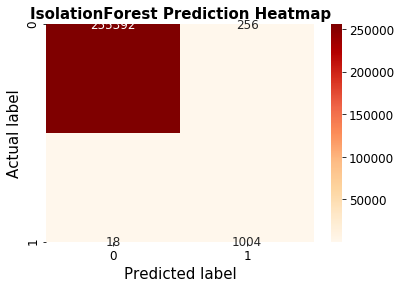

In [54]:
ax = sns.heatmap(metrics.confusion_matrix(df_true_labels['is_anomaly'], df['anomaly']), cmap="OrRd",annot=True, fmt="d")
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
plt.title('IsolationForest Prediction Heatmap', size = 15, y=1.08, fontweight="bold")

## Extracting results to CSV file:

In [22]:
results = df.filter(['record_ID','anomaly'], axis=1)
results = results.rename(columns={"anomaly": "my_label"})
results['real_label'] = df_true_labels[["is_anomaly"]]
results.to_csv('outlier_results.csv', index=False, sep='\t')

### Assignment Questions:
NOTE: I added some markdown explanations during some of the steps that I took during this assignment, so I might reference to some cells above as not to be repetitive.

### 1.) Data exploration - what have you learned?
#### To properly explore the data and find as much information as I could, I used pandas to find additional information about the dataset and the features themselves and their correlation with one another. In addition, I built some scatter plots in order to try and see if I can recongnize any outliers right away just from looking at the plots. 
#### What I took from that was the most of the time, the number of data bytes transfered from the destination to the source is a lot bigger than the the number of data bytes transfered from the source to the destination. With the average dst_byte size being almost 10x bigger than the average src_byte size.

#### The dataset was clean without any null values so we didn't have to use any fill_na methods or any dummies.

### 2.) Which algorithms group are suitable for this task and why? 

#### Given that the dataset which was given to us was unlabeled, it makes this problem an unsupervised anomaly detection problem (which is usually the most common type for anomaly detection).
#### Unsupervised anomaly detection techniques detect anomalies in an unlabeled test data set under the assumption that the majority of the instances in the data set are normal by looking for instances that seem to fit least to the remainder of the data set.
#### There are a couple different outlier detection algorithms suitable for this task, I chose to work with Isolation Forest, I will explain why in the next question.